## Compare MSE loss,BinaryCrossEntropy loss and Dice loss
Train on 1500 train images for 60 epochs.<br>

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from PIL import Image
from torch.utils import data
import time
import os
import copy
import json
import random

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
def Train_transform(image,mask,flip=True):
    image = tf.resize(image, (224,224))
    mask = tf.resize(mask, (224,224)) 
    
    if flip==True:
        if random.random() > 0.5:
            image = tf.hflip(image)
            mask = tf.hflip(mask)
        if random.random() > 0.5:
            image = tf.vflip(image)
            mask = tf.vflip(mask)
#         image = tf.adjust_contrast(image,random.uniform(0.6,1.5))
#         image = tf.adjust_hue(image,random.uniform(-0.5,0.5))
#         image = tf.adjust_brightness(image,random.uniform(0.6,1.5))
    
    image = tf.to_tensor(image)
    mask = tf.to_tensor(mask)
    image = tf.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return image, mask

def Other_transform(image,mask):
    return Train_transform(image,mask,False)

data_transform = {'train': Train_transform, 'eval': Other_transform, 'test': Other_transform}

In [5]:
class LIPDataset(data.Dataset):
    
    def __init__(self, root=None, img_path=None, mask_path=None, num_images=300, transform=None):   
        
        self.root = root
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
        
        self.table=[1]*256
        self.table[0]=0
        
        self.images = []
        self.masks = []
        c = 0
        for name in list(sorted(os.listdir(os.path.join(root,img_path)))):
            if c == num_images:
                break
            im = os.path.join(root,img_path,name)
            ma = os.path.join(root,mask_path,name[:-4]+'.png')
            if self.is_valid_image(im) and self.is_valid_image(ma):
                self.images.append(im)
                self.masks.append(ma)
                c+=1
            else:
                print('img and mask failed to be opened:')
                print(im)
                print(ma)
        
    def is_valid_image(self, path):
        try:
            i = Image.open(path)
            valid = True
        except:
            valid = False
        return valid
        
    def __getitem__(self, idx):
        
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        mask = mask.point(self.table,'1')
        if self.transform:
            image, mask = self.transform(image,mask)
        return image, mask
   
    def __len__(self):
        return len(self.images)

In [6]:
def load_data(TRAIN_BS, num_train, num_eval):
    data_dir = {'root': '/kaggle/input/singleperson', 
                'train': ('TrainVal_images/TrainVal_images/train_images','TrainVal_parsing_annotations/TrainVal_parsing_annotations/TrainVal_parsing_annotations/train_segmentations',num_train),
                'eval': ('TrainVal_images/TrainVal_images/val_images','TrainVal_parsing_annotations/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations',num_eval),
#                 'test': ('Testing_images/Testing_images/testing_images', )
               }
    since = time.time()
    datasets = {x: LIPDataset(data_dir['root'], data_dir[x][0], data_dir[x][1], data_dir[x][2], data_transform[x]) for x in ['train', 'eval']}
    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'eval']}
    print(dataset_sizes)
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['eval']}
    dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=TRAIN_BS, shuffle=True, num_workers=4)
    time_elapsed = time.time() - since
    print('Data loading complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    return datasets, dataloaders, dataset_sizes, device

In [7]:
def imshow(phase):
    print(phase + ' images:')
    imgs, masks = next(iter(dataloaders[phase]))
    im = torchvision.utils.make_grid(imgs)
    im = im.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = std * im + mean
    im = np.clip(im, 0, 1)
    plt.imshow(im);
    plt.pause(0.001)
    ma = torchvision.utils.make_grid(masks)
    ma = ma.numpy().transpose((1, 2, 0))
    ma = np.clip(ma, 0, 1)
    plt.imshow(ma);
    plt.pause(0.001)

In [8]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x

    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.up(x)
        return x

    
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=3,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,1,kernel_size=1,stride=1,padding=0)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_() 
    
    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return torch.sigmoid(d1)

In [9]:
def mIOU(pred,target):
    batch_accs = 0.0
    for img in range(pred.size(0)):
        pred_inds = pred[img,0,:,:] == 1
        target_inds = target[img,0,:,:] == 1
        intersection = (pred_inds[target_inds]).sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        batch_accs += float(intersection)/float(max(union,1))
    return batch_accs


def train_model(model, criterion, optimizer, scheduler, num_epochs, sch=False):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
    lrs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iters = len(dataloaders['train'])
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_accs = 0.0
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    o = outputs.cuda().data.cpu().numpy()
                    preds = torch.tensor((o>0.5).astype(np.float32)).to(device)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
                        if sch:
                            scheduler.step(epoch + step / iters)
                        
                running_loss += loss.item() * inputs.size(0)
                running_accs += mIOU(preds,labels)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_accs / dataset_sizes[phase]
            
            statistics[phase][0].append(epoch_loss)
            statistics[phase][1].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    return model, statistics, lrs

In [10]:
def visualize_accuracy(num_epochs, statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.savefig(fig_name)

In [11]:
def get_fixed_imgs():
    phases = ['train','eval']
    subsets = {x: torch.utils.data.Subset(datasets[x], np.arange(8)) for x in phases}
    new_loader= {x: torch.utils.data.DataLoader(subsets[x], batch_size=8, shuffle=False) for x in phases}
    dic = {x:{} for x in phases} # 'images','masks','outputs','preds'
    for phase in phases:
        inputs, labels = next(iter(new_loader[phase]))
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        o = outputs.cuda().data.cpu().numpy()
        preds = torch.tensor((o>0.5).astype(np.float32)).to(device)
        dic[phase]['images'] = inputs
        dic[phase]['masks'] = labels
        dic[phase]['outputs'] = outputs
        dic[phase]['preds'] = preds
    return dic


def visualize_performance(dic):
    fig = plt.figure()
    for keys,values in dic.items():
        print('Several images in ' + keys + ':')
        for k,v in values.items():
            im = torchvision.utils.make_grid(v[:8,:,:,:], nrow=4)
            im = im.cuda().data.cpu().numpy().transpose((1, 2, 0))
            if k == 'images':
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                im = std * im + mean
            im = np.clip(im, 0, 1)
            plt.imshow(im);
            plt.title(k)
            plt.pause(0.001)
    fig.show()

In [12]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):   
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

{'train': 1500, 'eval': 500}
Data loading complete in 0m 8s
cuda:0
train images:


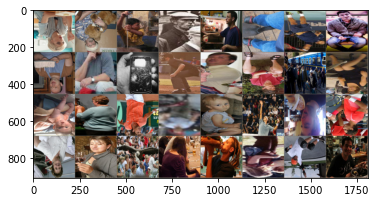

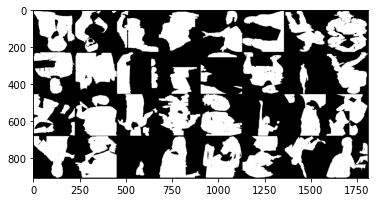

Epoch 0/59
----------
train Loss: 0.3480 Acc: 0.4856
eval Loss: 0.4196 Acc: 0.4013

Epoch 1/59
----------
train Loss: 0.3154 Acc: 0.5216
eval Loss: 0.3727 Acc: 0.4636

Epoch 2/59
----------
train Loss: 0.3074 Acc: 0.5305
eval Loss: 0.3325 Acc: 0.5053

Epoch 3/59
----------
train Loss: 0.3034 Acc: 0.5368
eval Loss: 0.3211 Acc: 0.5190

Epoch 4/59
----------
train Loss: 0.2986 Acc: 0.5412
eval Loss: 0.3120 Acc: 0.5250

Epoch 5/59
----------
train Loss: 0.2957 Acc: 0.5434
eval Loss: 0.3623 Acc: 0.4640

Epoch 6/59
----------
train Loss: 0.2947 Acc: 0.5443
eval Loss: 0.3131 Acc: 0.5303

Epoch 7/59
----------
train Loss: 0.2922 Acc: 0.5485
eval Loss: 0.3084 Acc: 0.5301

Epoch 8/59
----------
train Loss: 0.2876 Acc: 0.5533
eval Loss: 0.3018 Acc: 0.5381

Epoch 9/59
----------
train Loss: 0.2864 Acc: 0.5524
eval Loss: 0.3007 Acc: 0.5330

Epoch 10/59
----------
train Loss: 0.2814 Acc: 0.5590
eval Loss: 0.2928 Acc: 0.5494

Epoch 11/59
----------
train Loss: 0.2788 Acc: 0.5621
eval Loss: 0.2772 Acc

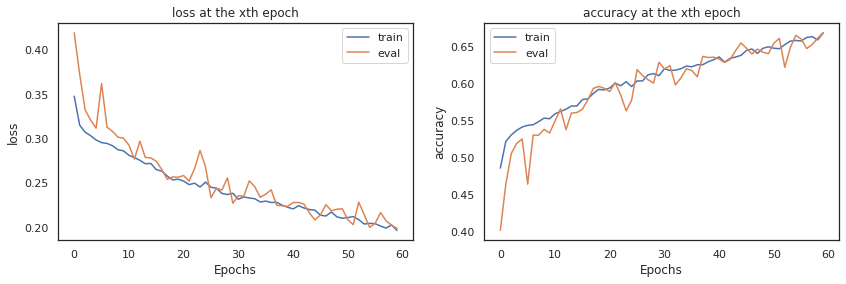

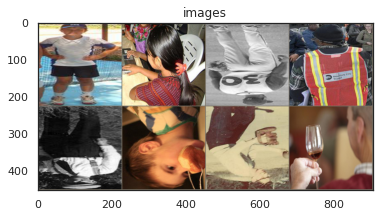

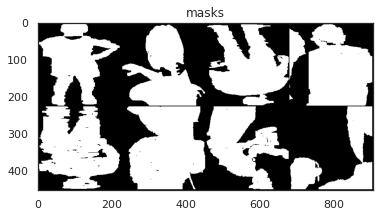

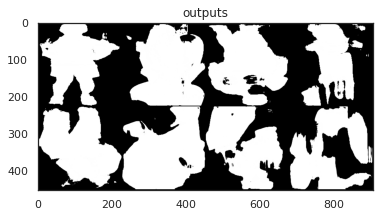

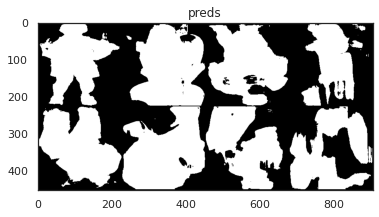

Several images in eval:


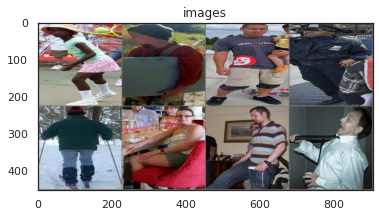

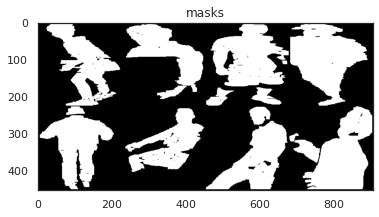

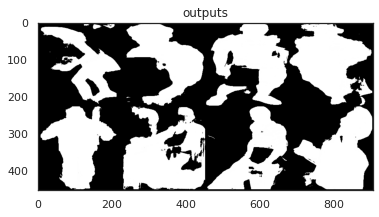

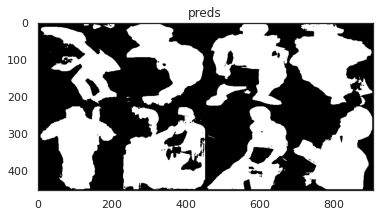

In [13]:
# Dice

setup_seed(20)
datasets, dataloaders, dataset_sizes, device = load_data(32, 1500, 500)
imshow('train')

model = UNet()
model = model.to(device)
num_epochs = 60

# criterion = nn.MSELoss()
criterion = DiceLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
cosine_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= int(1.3*num_epochs), T_mult=1, eta_min=0, last_epoch=-1)
 
model, statistics, lrs = train_model(model, criterion, optimizer, cosine_lr_scheduler, num_epochs=num_epochs, sch=False)

name = 'UN_1500_60e_Dice'

json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(num_epochs, statistics, name+'.png')
visualize_performance(get_fixed_imgs())
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')